# Install dependencies and import:

dependencies can be install via dependencies.yml

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the data and split training and testing data

Loading the data and the data column we want. Previously, we see that Finals (CK), Progress (QT_y) is highly corelleated. So our model should focus on it first:

In [33]:
df = pd.read_csv("data/output.csv")
df_copy = df.copy()
X = df[["CK", "QT_y"]]  # Features (Predictors)
y = df["HP_grade"]  # Target variable

Then, we split the training data:

- 80% training data provides enough information for the model to learn patterns effectively.
- 20% test data ensures a reliable estimate of how the model performs on unseen data.

In [34]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We take a small peek to the training and testing dataset to see if spliting and choosing sucesss:

In [35]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.head())
print(y_train.head())
print(X_test.head())
print(y_test.head())

(131, 2)
(131,)
(33, 2)
(33,)
     CK  QT_y
84  6.5   6.5
2   9.5   8.5
94  9.0   7.0
45  6.0   5.5
42  6.5   7.5
84    6.5
2     9.2
94    8.4
45    5.9
42    6.8
Name: HP_grade, dtype: float64
      CK  QT_y
135  7.5   7.5
115  6.5   7.5
131  8.0   6.5
55   6.0   7.5
95   6.5   7.5
135    7.5
115    6.8
131    7.6
55     6.5
95     6.8
Name: HP_grade, dtype: float64


There are 131 samples for training and 33 for testing.

# Step 2: Initialize and train the model:

Then, we initiate the learning model:

In [36]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Predict on the test set
y_pred = lr.predict(X_test)


We can get regression coefficients with ```lr.coef_``` and ```lr.intercept_```

In [37]:
# Get the coefficients (slope values for each feature)
coeff_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr.coef_})
print(coeff_df)

# Get the intercept (y-intercept)
intercept = lr.intercept_

print("Intercept:", intercept)

  Feature  Coefficient
0      CK     0.701524
1    QT_y     0.296688
Intercept: 0.032323621783088896


# Step 3: Grading model 

We evaluate model performance using mean squared error, root mean squared error and R^2.

In [38]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.6f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error: 0.000718
Root Mean Squared Error: 0.0268
R-squared (R²): 0.9996


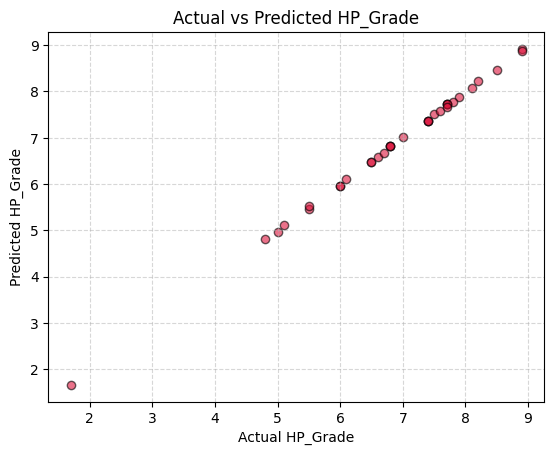

In [39]:
# Visualize actual vs predicted
plt.scatter(y_test, y_pred, color="crimson", alpha=0.6, edgecolors="black")
plt.xlabel("Actual HP_Grade")
plt.ylabel("Predicted HP_Grade")
plt.title("Actual vs Predicted HP_Grade")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Overall, models work exceptionally well. With R value very close to 1 and the grade only deviate at the rate of 0.0268 in scale of 10

# Step 4: Optimization

## Approach 1: Anomaly removal

In EDA, we have seen some anomalies across the columns, let's try to remove them:


In [40]:
df = df[df["HP_grade"] >= 3]
df = df[df["QT_x"] >= 3]
#df = df[df["QT_y"] >= 3]
#df = df[df["KT3"] >= 2]
#df = df[df["KT1"] >= 3]
#df = df[df["BC"] >= 4]

In [41]:
X = df[["CK", "QT_x"]]  # Features (Predictors)
y = df["HP_grade"]  # Target variable

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [42]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Predict on the test set
y_pred = lr.predict(X_test)

In [43]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [44]:
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error: 0.0021
Root Mean Squared Error: 0.0461
R-squared (R²): 0.9986


We see that reducing anomalies make model worse. We have deleted valuable data.

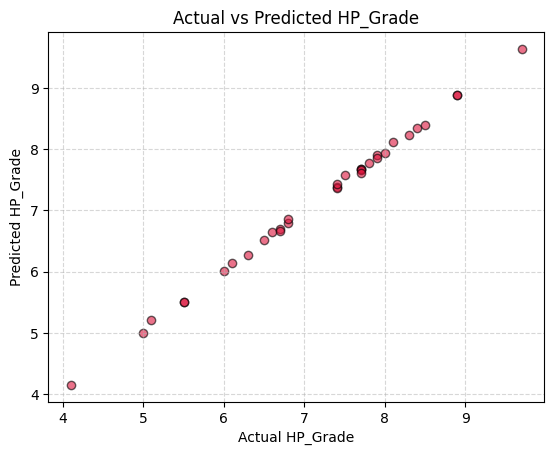

In [45]:
# Visualize actual vs predicted
plt.scatter(y_test, y_pred, color="crimson", alpha=0.6, edgecolors="black")
plt.xlabel("Actual HP_Grade")
plt.ylabel("Predicted HP_Grade")
plt.title("Actual vs Predicted HP_Grade")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Approach 2: Apply K-Fold training

- K-Fold Cross-Validation is a technique used to evaluate a model's performance by splitting the dataset into K equal parts (folds) and training the model multiple times on different subsets of the data.

1. How Does K-Fold Work?
- Divide the dataset into K folds
- If K=5, the dataset is split into 5 equal parts. Train the model K times
- Each time, use K-1 folds for training and 1 fold for testing. Compute the average performance
- The final result is the mean of all K test scores, giving a more reliable estimate of model performance.
2. Why Use K-Fold?
- Reduces Bias → Uses all data for both training & testing.
- More Reliable → Reduces dependency on a single train-test split.
- Better for Small Datasets → Maximizes data usage.

In [46]:
X = df_copy[["CK", "QT_y"]]  # Features (Predictors)
y = df_copy["HP_grade"]  # Target variable

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV
model = LinearRegression()

# Perform Cross-Validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert to positive MSE values
mse_scores = -mse_scores

# Print results
print(f'MSE Scores for each fold: {mse_scores}')
print(f'Average MSE: {np.mean(mse_scores)}')
print(f'Standard Deviation of MSE: {np.std(mse_scores)}')


MSE Scores for each fold: [0.00071783 0.00078797 0.00073673 0.00074249 0.00076185]
Average MSE: 0.0007493749517986849
Standard Deviation of MSE: 2.386456235010309e-05


The average MSE is worse than original model's MSE.